In [1]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTConfig, BertTokenizer, ViTImageProcessor
from datasets import load_dataset
from PIL import Image
from datasets import DatasetDict

import numpy as np
import random

In [16]:
# Load the dataset
dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")  # Replace with your dataset path or identifier

# Initialize the tokenizer (you can choose a different tokenizer if preferred)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define image transformations
# image_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # ViT typically expects 224x224 images
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
#                          std=[0.229, 0.224, 0.225]),
# ])

processor = ViTImageProcessor().from_pretrained('google/vit-base-patch16-224-in21k')

# Preprocessing function
def preprocess_function(examples):
    # Process images
    images = [image.convert("RGB") for image in examples['image']]
    encoding = processor(images=images)
    examples['pixel_values'] = encoding['pixel_values']

    # Tokenize captions
    captions = examples['text']
    encoding = tokenizer(captions, padding='max_length', truncation=True, max_length=224)
    examples['input_ids'] = encoding['input_ids']
    examples['attention_mask'] = encoding['attention_mask']

    return examples

# Step 1: Split into train_val and test
train_val_split = dataset['train'].train_test_split(test_size=1250, seed=42)  # 10% for test
train_val = train_val_split['train']
test = train_val_split['test']

# Step 2: Split train_val into train and validation
train_validation_split = train_val.train_test_split(test_size=1250, seed=42)
train = train_validation_split['train']
validation = train_validation_split['test']

# Step 3: Create a new DatasetDict with the splits
new_dataset = DatasetDict({
    'train': train,
    'validation': validation,
    'test': test
})

# Optional: Verify the splits
# processed_ds_train = new_dataset['train'].map(preprocess_function, batched=True, batch_size=100, remove_columns=['text', 'image'])
# processed_ds_val = new_dataset['validation'].map(preprocess_function, batched=True, batch_size=100, remove_columns=['text', 'image'])
processed_ds_test = new_dataset['test'].map(preprocess_function, batched=True, batch_size=100)

# processed_ds_train.set_format(
#     type='torch',
#     columns=['pixel_values', 'input_ids', 'attention_mask']
# )

# processed_ds_val.set_format(
#     type='torch',
#     columns=['pixel_values', 'input_ids', 'attention_mask']
# )

processed_ds_test.set_format(
    type='torch',
    columns=['pixel_values', 'input_ids', 'attention_mask'],
    output_all_columns=True
)

In [ ]:
# Define training parameters
batch_size = 32

# Create DataLoader for training
train_loader = DataLoader(processed_ds_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(processed_ds_val, batch_size=batch_size, shuffle=True)

In [6]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, decoder_layers, decoder_heads, decoder_ffn_dim, max_seq_length=224):
        super(ImageCaptioningModel, self).__init__() #initialize from parent .init()

        # Encoder: Vision Transformer (ViT)
        vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
        vit_config.num_hidden_layers = 6  # Reduce the number of layers to 4-6
        self.encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=vit_config)

        # Decoder: Transformer
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=decoder_heads, dim_feedforward=decoder_ffn_dim)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=decoder_layers)

        # Embedding for input tokens
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, embed_dim)) # ??????????????

        # Final linear layer to generate vocabulary scores
        self.output_linear = nn.Linear(embed_dim, vocab_size)

        # Projection to match dimensions
        self.encoder_proj = nn.Linear(vit_config.hidden_size, embed_dim)

    def forward(self, pixel_values, input_ids, attention_mask):
        # Encoder
        encoder_outputs = self.encoder(pixel_values=pixel_values)
        encoder_hidden_states = encoder_outputs.last_hidden_state  # (batch_size, num_patches + 1, hidden_size)
        # Project encoder outputs to embed_dim
        encoder_proj = self.encoder_proj(encoder_hidden_states)  # (batch_size, seq_len, embed_dim)
        encoder_proj = encoder_proj.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)

        # Decoder
        embeddings = self.token_embedding(input_ids) + self.positional_encoding[:, :input_ids.size(1), :]
        embeddings = embeddings.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)

        # Create a causal mask for the decoder to prevent attending to future tokens
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(input_ids.size(1)).to(pixel_values.device)

        decoder_outputs = self.decoder(embeddings, encoder_proj, tgt_mask=tgt_mask, tgt_key_padding_mask=~attention_mask.bool())
        decoder_outputs = decoder_outputs.permute(1, 0, 2)  # (batch_size, seq_len, embed_dim)

        outputs = self.output_linear(decoder_outputs)  # (batch_size, seq_len, vocab_size)

        return outputs

In [7]:
# Define vocabulary size and other hyperparameters
vocab_size = tokenizer.vocab_size
embed_dim = 512
decoder_layers = 6  # 4-6 layers as per requirement
decoder_heads = 8
decoder_ffn_dim = 2048
max_seq_length = 224

# Initialize the model
model = ImageCaptioningModel(vocab_size, embed_dim, decoder_layers, decoder_heads, decoder_ffn_dim, max_seq_length)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Define separate learning rates
learning_rate_encoder = 1e-5  # Lower learning rate for pre-trained encoder
learning_rate_decoder = 1e-4  # Higher learning rate for decoder
# Create parameter groups
optimizer = optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': learning_rate_encoder},
    {'params': model.decoder.parameters(), 'lr': learning_rate_decoder},
    {'params': model.token_embedding.parameters(), 'lr': learning_rate_decoder},
    {'params': model.encoder_proj.parameters(), 'lr': learning_rate_decoder},
    {'params': model.output_linear.parameters(), 'lr': learning_rate_decoder}
], betas=(0.9, 0.98), eps=1e-9)

# Initialize the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=2,
                                                 verbose=True, min_lr=1e-6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['encoder.layer.10.attention.attention.key.bias', 'encoder.layer.10.attention.attention.key.weight', 'encoder.layer.10.attention.attention.query.bias', 'encoder.layer.10.attention.attention.query.weight', 'encoder.layer.10.attention.attention.value.bias', 'encoder.layer.10.attention.attention.value.weight', 'encoder.layer.10.attention.output.dense.bias', 'encoder.layer.10.attention.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.layernorm_after.bias', 'encoder.layer.10.layernorm_after.weight', 'encoder.layer.10.layernorm_before.bias', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.attention.attention.key.bias', 'encoder.layer.11.attention.attention.key.weight', 'encoder.layer.11.attention.attention.q

In [ ]:
def generate_caption(model, image, processor ,tokenizer, device, max_length=224):
    model.eval()
    with torch.no_grad():
        # Encode image
        encoder_outputs = model.encoder(pixel_values=image.unsqueeze(0))
        encoder_hidden_states = model.encoder_proj(encoder_outputs.last_hidden_state).permute(1, 0, 2)

        # Initialize decoder input with [CLS] or <start> token
        # Assuming you have a <start> token, else use tokenizer.bos_token_id
        input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)  # (1, 1)
        generated = []

        for _ in range(max_length):
            embeddings = model.token_embedding(input_ids) + model.positional_encoding[:, :input_ids.size(1), :]
            embeddings = embeddings.permute(1, 0, 2)

            decoder_outputs = model.decoder(embeddings, encoder_hidden_states)
            decoder_outputs = decoder_outputs.permute(1, 0, 2)
            outputs = model.output_linear(decoder_outputs)

            # Get the last token
            next_token_logits = outputs[:, -1, :]  # (1, vocab_size)

            next_token = next_token_logits.argmax(dim=-1).unsqueeze(0)  # (1, 1)

            if next_token.item() == tokenizer.sep_token_id:
                break
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token], dim=1)

        caption = tokenizer.decode(generated, skip_special_tokens=True)
        return caption

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_val_loss = 0
    for batch in train_loader:
        pixel_values = batch['pixel_values'].to(device)  # (batch_size, 3, 224, 224)
        input_ids = batch['input_ids'].to(device)        # (batch_size, seq_length)
        attention_mask = batch['attention_mask'].to(device)  # (batch_size, seq_length)

        # Shift input_ids and create labels
        # Typically, input_ids are shifted right for the decoder input
        # Labels are the actual tokens to predict
        labels = input_ids[:, 1:].contiguous()
        decoder_input_ids = input_ids[:, :-1].contiguous()
        decoder_attention_mask = attention_mask[:, :-1].contiguous()

        optimizer.zero_grad()

        outputs = model(pixel_values, decoder_input_ids, decoder_attention_mask)
        # outputs: (batch_size, seq_length -1, vocab_size)

        loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch['pixel_values'].to(device)  # (batch_size, 3, 224, 224)
            input_ids = batch['input_ids'].to(device)        # (batch_size, seq_length)
            attention_mask = batch['attention_mask'].to(device)  # (batch_size, seq_length)

            labels = input_ids[:, 1:].contiguous()
            decoder_input_ids = input_ids[:, :-1].contiguous()
            decoder_attention_mask = attention_mask[:, :-1].contiguous()

            outputs = model(pixel_values, decoder_input_ids, decoder_attention_mask)

            loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))

            epoch_val_loss += loss.item()

        for _ in range(3):
            index = random.randint(0, len(processed_ds_test)-1)
            image = processed_ds_test[index]['pixel_values'].to(device)
            caption = generate_caption(model, image, processor ,tokenizer, device)
            print(caption)

    image = processed_ds_test[0]['pixel_values'].to(device)
    caption = generate_caption(model, image, processor ,tokenizer, device)
    print(caption)


    avg_val_loss = epoch_val_loss / len(val_loader)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, val_loss: {avg_val_loss:.4f}, lr: {scheduler.get_last_lr()}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


solid black long - sleeved top in a soft ribbed jersey with a ribbed hem
solid dark blue short skirt in a crepe weave with a concealed zip at the back and a concealed zip at the hem unlined
all over pattern light beige long - sleeved top in a soft ribbed hems
solid black short dress in a crepe weave with a concealed zip at the back and a seam at the waist unlined
Epoch 1/10, Loss: 3.2062, val_loss: 1.7094, lr: [1e-05, 0.0001, 0.0001, 0.0001, 0.0001]
solid dark blue short fitted dress in a soft ribbed jersey with a slightly wider neckline and short sleeves
solid black short skirt in a sturdy weave with a concealed zip and zip at the side and a concealed zip and side lined
solid light beige jumper in a soft rib knit containing some wool with a ribbed neckline and long sleeves
solid black calf - length skirt in a crepe weave with a concealed zip at the back and a concealed zip at the back and straight legs
Epoch 2/10, Loss: 1.5078, val_loss: 1.3355, lr: [1e-05, 0.0001, 0.0001, 0.0001, 0.0

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/VIT+decoder/VIT_decoder.pth')

In [8]:
model.load_state_dict(torch.load('/content/drive/MyDrive/VIT+decoder/VIT_decoder.pth'))
model.eval()  # Set the model to evaluation mode

<ipython-input-8-111cb6093e44>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/VIT+decoder/VIT_decoder.pth'))


ImageCaptioningModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-5): 6 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featu

In [17]:
processed_ds_test

Dataset({
    features: ['text', 'image', 'pixel_values', 'input_ids', 'attention_mask'],
    num_rows: 1250
})

generated captions: solid black jumper in a soft fine - knit viscose and cotton blend with a v - neck long sleeves and ribbing at the cuffs
ground truth: solid black jumper in a soft fine-knit viscose blend with a deep v-neck long sleeves and ribbing around the neckline cuffs and hem


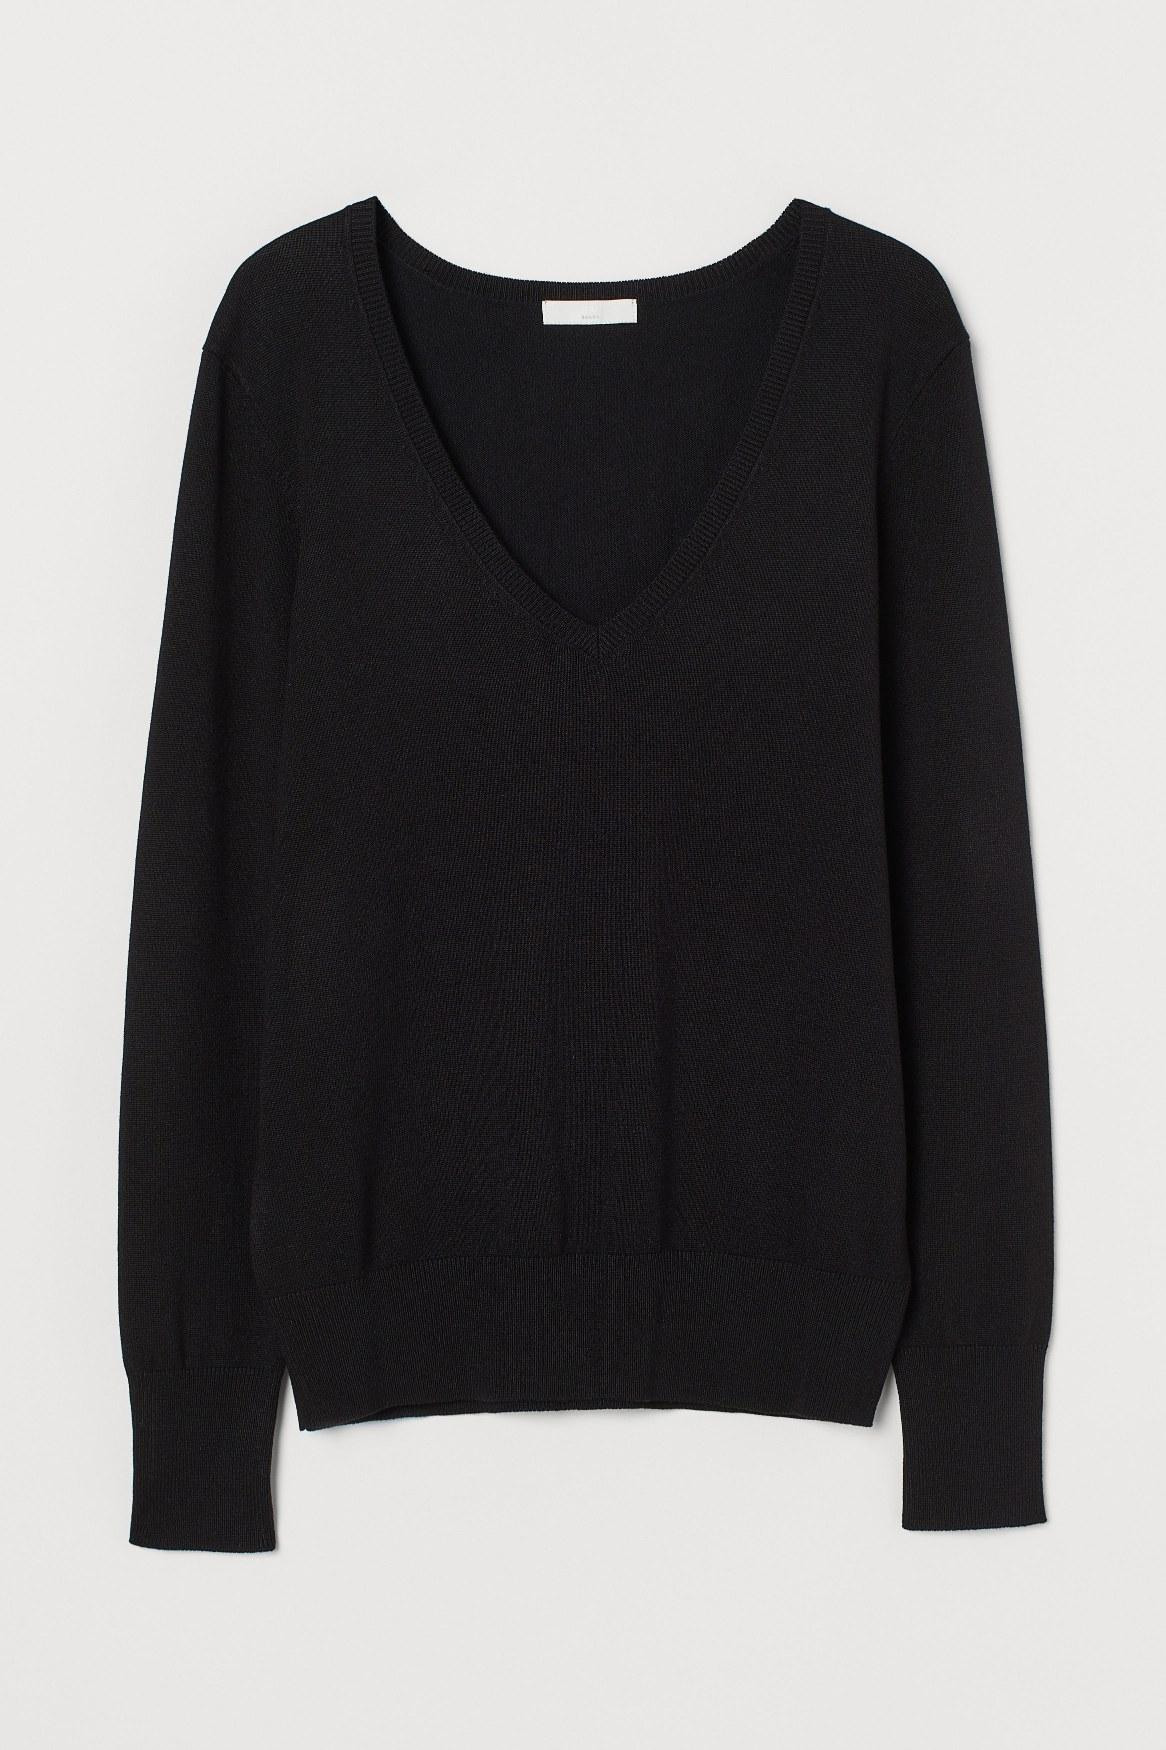

In [19]:
def generate_caption(model, image, processor ,tokenizer, device, max_length=224):
    model.eval()
    with torch.no_grad():
        # Encode image
        encoder_outputs = model.encoder(pixel_values=image.unsqueeze(0))
        encoder_hidden_states = model.encoder_proj(encoder_outputs.last_hidden_state).permute(1, 0, 2)

        # Initialize decoder input with [CLS] or <start> token
        # Assuming you have a <start> token, else use tokenizer.bos_token_id
        input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)  # (1, 1)
        generated = []

        for _ in range(max_length):
            embeddings = model.token_embedding(input_ids) + model.positional_encoding[:, :input_ids.size(1), :]
            embeddings = embeddings.permute(1, 0, 2)

            decoder_outputs = model.decoder(embeddings, encoder_hidden_states)
            decoder_outputs = decoder_outputs.permute(1, 0, 2)
            outputs = model.output_linear(decoder_outputs)

            # Get the last token
            next_token_logits = outputs[:, -1, :]  # (1, vocab_size)

            next_token = next_token_logits.argmax(dim=-1).unsqueeze(0)  # (1, 1)

            if next_token.item() == tokenizer.sep_token_id:
                break
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token], dim=1)

        caption = tokenizer.decode(generated, skip_special_tokens=True)
        return caption

# Example usage:
image = processed_ds_test[1]['pixel_values'].to(device)
caption = generate_caption(model, image, processor ,tokenizer, device)
print(f"generated captions: {caption}")
print(f"ground truth: {processed_ds_test[1]['text']}")
processed_ds_test[1]['image']

In [ ]:
# compute metric before beam-search
# Beam-search